In [1]:
import os
import sys
import re
import glob
import h5py

os.chdir('/home/yajatyadav/multitask_reinforcement_learning/multitask_RL')
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# # Add libero path before importing libero_utils
# libero_path = '/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/libero/libero'
# if libero_path not in sys.path:
#     sys.path.insert(0, libero_path)

from envs.env_utils import make_env_and_datasets

In [2]:
def extract_libero_task_name(fp):
    fp = os.path.basename(fp).split('.')[0][:-5]
    if "SCENE" in fp:
        match = re.search(r'\d+', fp)
        fp = fp[match.end() + 1:]
    print(f'TASK NAME IS: {fp}')        
    return fp

from utils.datasets import Dataset
# handle dataset
def process_train_dataset(ds):
    """
    Process the train dataset to 
        - handle dataset proportion
        - handle sparse reward
        - convert to action chunked dataset
    """

    ds = Dataset.create(**ds)
    
    print(f"main.py:Translating dataset rewards by -1")
    penalty_rewards = ds["rewards"] - 1.0
    ds_dict = {k: v for k, v in ds.items()}
    ds_dict["rewards"] = penalty_rewards
    ds = Dataset.create(**ds_dict)
    
    # print(f"main.py: Sparsifiying rewards by setting all non-zero rewards to -1")
    # # Create a new dataset with modified rewards instead of trying to modify the frozen one
    # sparse_rewards = (ds["rewards"] != 0.0) * -1.0
    # ds_dict = {k: v for k, v in ds.items()}
    # ds_dict["rewards"] = sparse_rewards
    # ds = Dataset.create(**ds_dict)
    return ds

In [ ]:
# load in a demo traj for living_room_scene1

suite_dir = '/home/yajatyadav/multitask_reinforcement_learning/datasets/raw_libero/LIBERO_90'
scene_pattern = 'LIVING_ROOM_SCENE1_*_demo.hdf5'

keys_to_load = ['agentview_rgb', 'eye_in_hand_rgb', 'proprio', 'language']
filepaths = glob.glob(os.path.join(suite_dir, scene_pattern))

ENV_NAME = 'libero_90-living_room_scene1'

task_to_datasets = {}

for filepath in filepaths:
    task_name = extract_libero_task_name(filepath)

    env, eval_env, train_dataset, val_dataset, names_to_return = make_env_and_datasets(
    ENV_NAME,
    task_name,
    'none',
    num_parallel_envs=1,
    keys_to_load=keys_to_load,
    use_hardcoded_eval_envs=False,
    demo_nums_to_use_per_task=[5],
    )
    task_to_datasets[task_name] = process_train_dataset(train_dataset)

[robosuite WARNING] No private macro file found! (__init__.py:7)
[robosuite WARNING] It is recommended to use a private macro file (__init__.py:8)
[robosuite WARNING] To setup, run: python /home/yajatyadav/multitask_reinforcement_learning/multitask_RL/.venv/lib/python3.11/site-packages/robosuite/scripts/setup_macros.py (__init__.py:9)


TASK NAME IS: pick_up_the_tomato_sauce_and_put_it_in_the_basket
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
TODO(YY): Normalization path not implemented for libero_90-living_room_scene1-pick_up_the_tomato_sauce_and_put_it_in_the_basket
evaluation environment will return keys:  {'robot0_eye_in_hand_image', 'proprio', 'agentview_image', 'language'}
suites: ['libero_90'], scenes: ['living_room_scene1']
All possible envs, sorted alphabetically: there are 1 total envs
 len(envs_to_eval)=4 Environments to evaluate: ['libero_90-LIVING_ROOM_SCENE1_pick_up_the_alphabet_soup_and_put_it_in_the_basket', 'libero_90-LIVING_ROOM_SCENE1_pick_up_the_cream_cheese_box_and_put_it_in_the_basket', 'libero_90-LIVING_ROOM_SCENE1_pick_up_the_ketchup_and_put_it_in_the_basket', 'libero_90-LIVING_ROOM_SCENE1_pick_up_the_tomato_sauce_and

Process Process-20:
Process Process-16:
Process Process-19:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/.venv/lib/python3.11/site-packages/robosuite/utils/observables.py", line 377, in _check_sensor_validity
    self._data_shape = np.array(self._sensor({})).shape
                                ^^^^^^^^^^^^^^^^
  File "/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/.venv/lib/python3.11/site-packages/robosuite/utils/observables.py", line 377, in _check_sensor_validity
    self._data_shape = np.array(self._sensor({})).shape
                                ^^^^^^^^^^^^^^^^
  File "/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/.venv/lib/python3.11/site-packages/robosuite/environments/robot_env.py", line 404, in camera_rgb
    img = self.sim.render(
          ^^^^^^^^^^^^^^^^
  File "/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/.venv/lib/python3

In [4]:
from agents.acifql import get_config
from agents import agents
from utils.flax_utils import restore_agent_actor_critic_separately, restore_agent_with_file

agent_config = get_config()
encoder = 'combined_encoder_small'
seed = 0
n = 16
horizon_length = 5
agent_config['encoder'] = encoder
agent_config['num_samples'] = n
agent_config['horizon_length'] = horizon_length

agent_class_str = 'acifql'
agent_class = agents[agent_class_str]


example_batch = train_dataset.sample_sequence(1, sequence_length=horizon_length, discount=0.99)
print(f"creating agent")
agent = agent_class.create(seed, example_batch['observations'], example_batch['actions'], agent_config)
print(f"restoring agent")

# actor_restore_path = '/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/exp/multitask_RL/instruction_following_Q/libero_90-living_room_scene1/libero90_livingroomscene1_none_augmentation_IMAGE_sd000s_30619172.0.20251225_012034/params_50000.pkl'
# critic_restore_path = '/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/exp/multitask_RL/instruction_following_Q/libero_90-living_room_scene1/libero90_livingroomscene1_none_augmentation_IMAGE_sd000s_30619172.0.20251225_012034/params_350000.pkl'
critic_restore_path ='/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/exp/multitask_RL/instruction_following_Q/libero_90-living_room_scene1/libero90_livingroomscene1_exhaustive_augmentation_IMAGE_sd00020251225_005048/params_750000.pkl'
label = (''.join(critic_restore_path.split('/')[-2:])).split('.')[0]
print(f"restoring agent with {label}")
agent = restore_agent_with_file(agent, critic_restore_path)
# agent = restore_agent_actor_critic_separately(agent, actor_restore_path, critic_restore_path)

/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/.venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/.venv/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:681: DeprecationWarning: jax.interpreters.xla.pytype_aval_mappings is deprecated.
  jax.interpreters.xla.pytype_aval_mappings[onp.ndarray])


creating agent
restoring agent
restoring agent with libero90_livingroomscene1_exhaustive_augmentation_IMAGE_sd00020251225_005048params_750000
Restored from /home/yajatyadav/multitask_reinforcement_learning/multitask_RL/exp/multitask_RL/instruction_following_Q/libero_90-living_room_scene1/libero90_livingroomscene1_exhaustive_augmentation_IMAGE_sd00020251225_005048/params_750000.pkl


# Plot 1: V(s) and Q(s, a) Values over a Dataset Trajectory

100%|██████████| 149/149 [00:29<00:00,  5.02it/s]


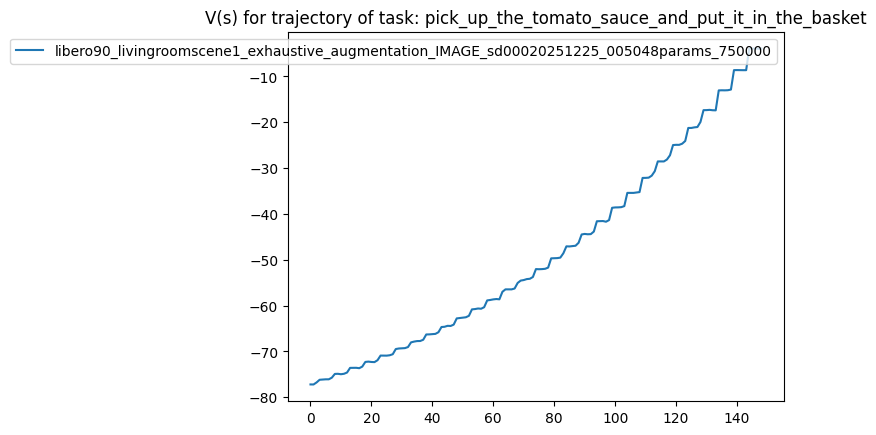

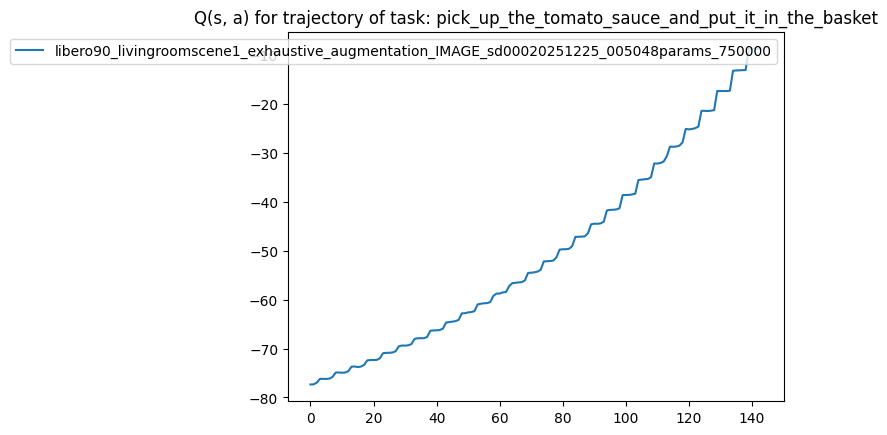

100%|██████████| 169/169 [00:22<00:00,  7.40it/s]


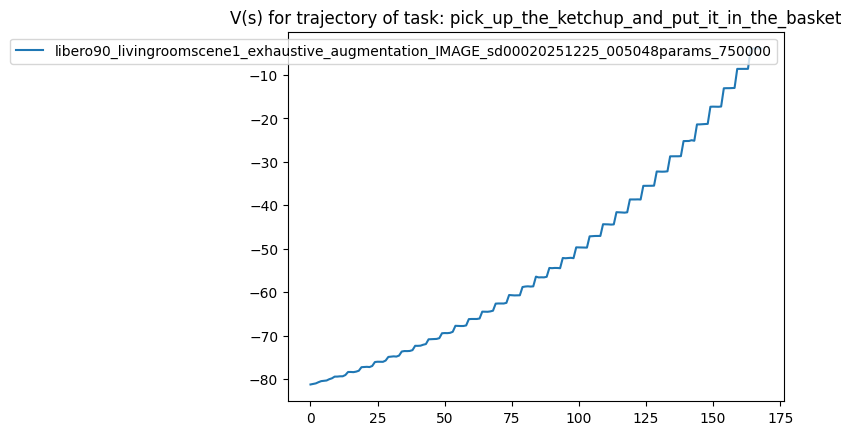

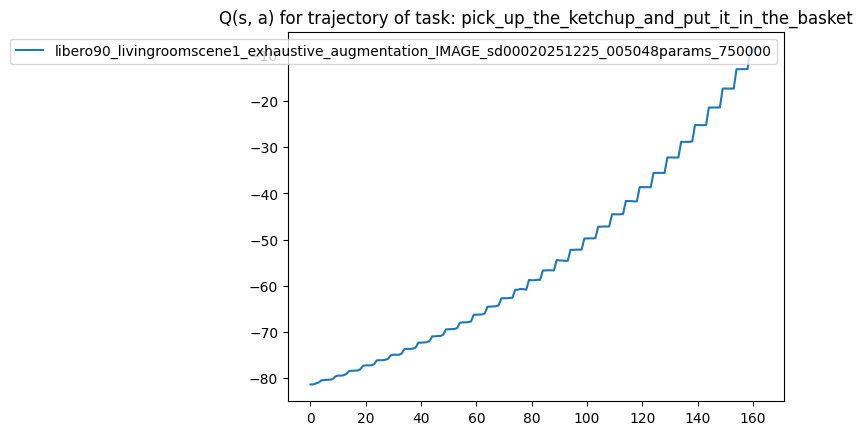

100%|██████████| 153/153 [00:20<00:00,  7.63it/s]


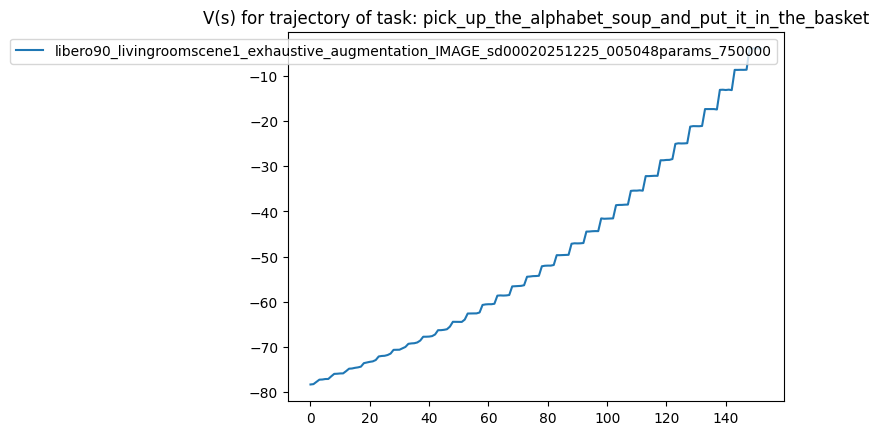

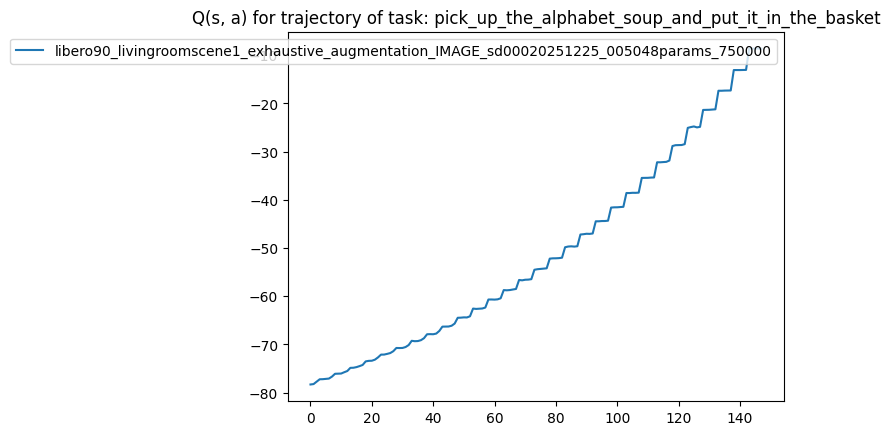

100%|██████████| 151/151 [00:20<00:00,  7.48it/s]


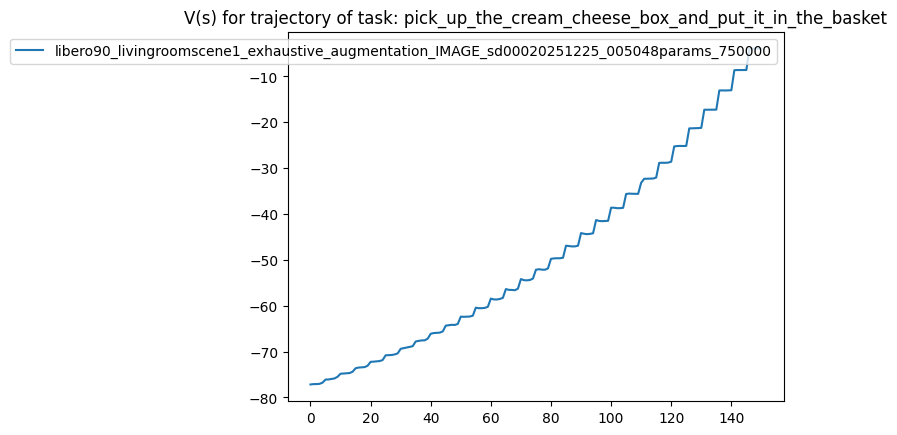

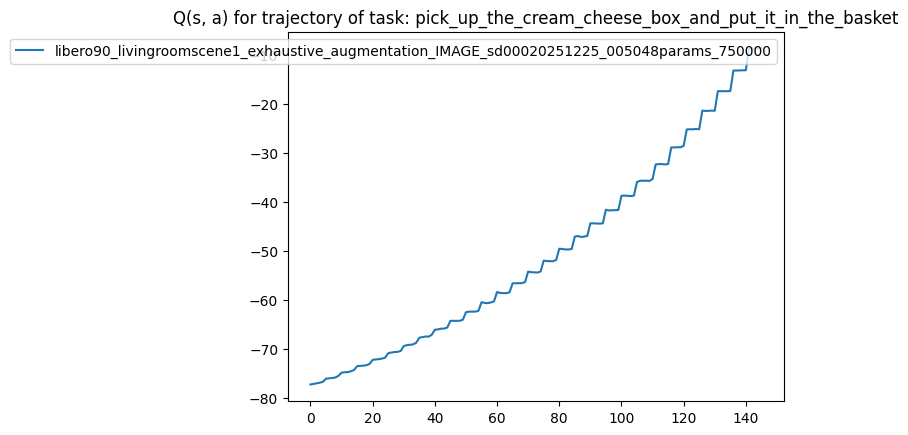

In [6]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

for task_name, train_dataset in task_to_datasets.items():
    traj_state_values = []
    traj_q_values = []
    traj_len = len(train_dataset['actions'])

    for i in tqdm(range(traj_len)):
        if i < traj_len - horizon_length:
            transition = train_dataset.sample_sequence(1, sequence_length=horizon_length, discount=0.99, idxs_to_use=np.array([i,]))
        else:
            transition = train_dataset.sample_sequence(1, sequence_length=traj_len - i, discount=0.99, idxs_to_use=np.array([i,]))
        
        # can go right to the end for V(s) but not Q(s,a) as actions are chunked
        v = agent.network.select('value')(transition['observations'])
        traj_state_values.append(v)

        if i < traj_len - horizon_length:            
            batch_actions = np.reshape(transition['actions'], (transition['actions'].shape[0], -1))
            q1, q2 = agent.network.select('critic')(transition['observations'], actions=batch_actions)
            q = np.minimum(q1, q2)
            traj_q_values.append(q)


    traj_state_values = np.concatenate(traj_state_values, axis=0)
    traj_q_values = np.concatenate(traj_q_values, axis=0)

    # plot traj_state_values
    plt.plot(traj_state_values, label=label)
    plt.title('V(s) for trajectory of task: ' + task_name)
    plt.legend()
    plt.show()

    # plot traj_q_values
    plt.plot(traj_q_values, label=label)
    plt.title('Q(s, a) for trajectory of task: ' + task_name)
    plt.legend()
    plt.show()

# Plot 2: Q(s, a) over the entire trajectory but using other dataset actions

100%|██████████| 144/144 [00:07<00:00, 18.35it/s]


stacking everything


Computing Q-values: 100%|██████████| 81/81 [00:15<00:00,  5.28it/s]
/tmp/ipykernel_4061006/164307675.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


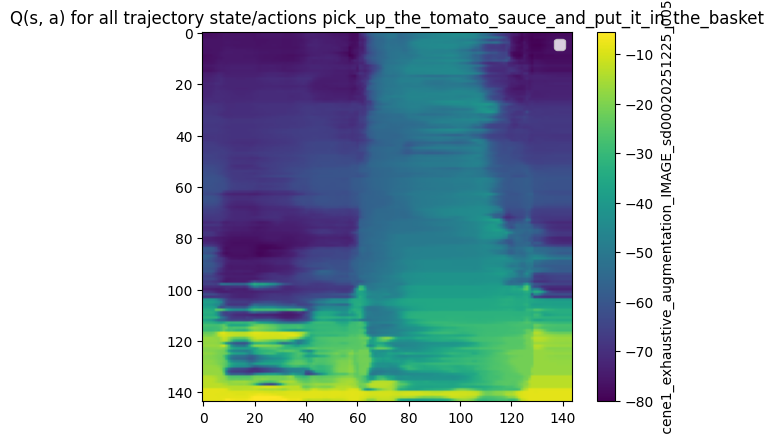

100%|██████████| 164/164 [00:10<00:00, 15.92it/s]


stacking everything


Computing Q-values: 100%|██████████| 106/106 [00:14<00:00,  7.27it/s]


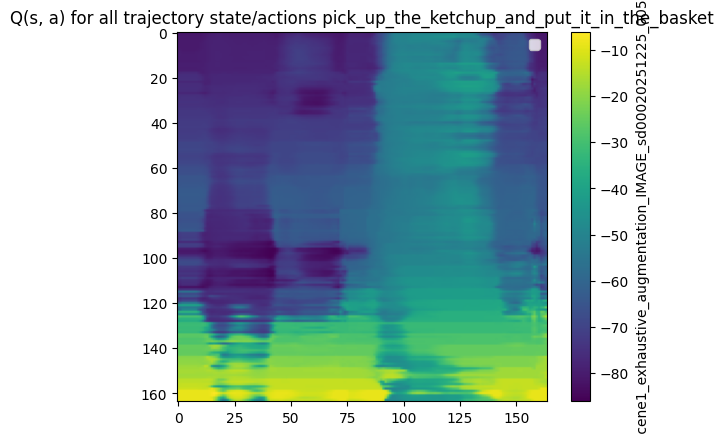

100%|██████████| 148/148 [00:08<00:00, 18.48it/s]


stacking everything


Computing Q-values: 100%|██████████| 86/86 [00:14<00:00,  5.92it/s]


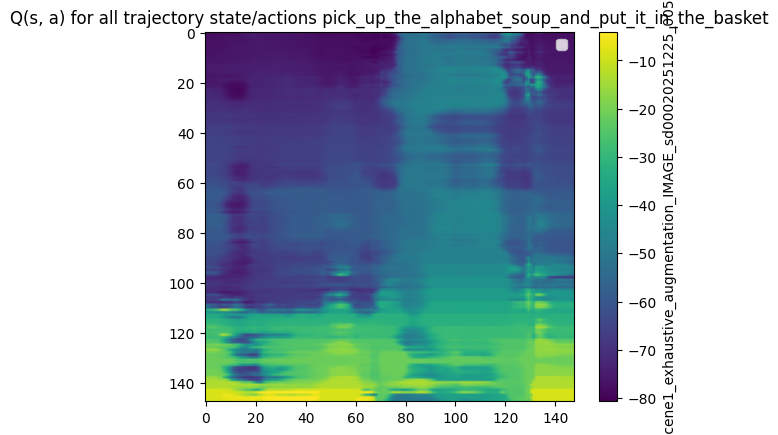

100%|██████████| 146/146 [00:07<00:00, 19.20it/s]


stacking everything


Computing Q-values: 100%|██████████| 84/84 [00:13<00:00,  6.17it/s]


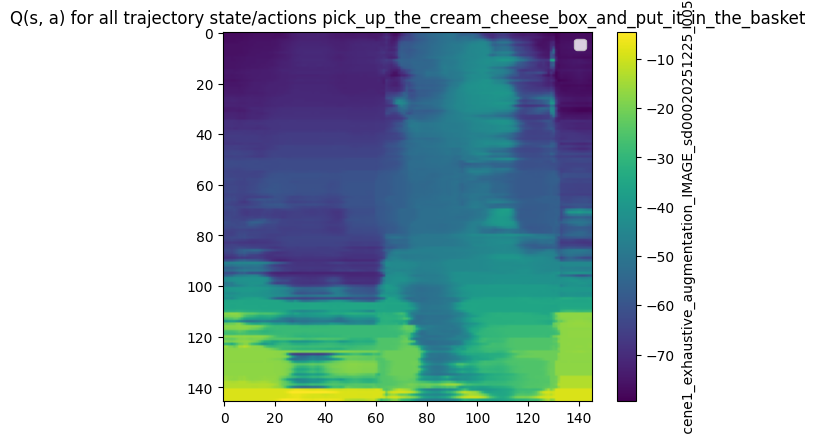

In [7]:
import jax
import jax.numpy as jnp

for task_name, train_dataset in task_to_datasets.items():
    traj_len = len(train_dataset['actions'])


    all_observations, all_actions = [], []
    for i in tqdm(range(traj_len - horizon_length)):
        for j in range(traj_len - horizon_length):
            transition_i = train_dataset.sample_sequence(1, sequence_length=5, discount=0.99, idxs_to_use=np.array([i,]))
            transition_j = train_dataset.sample_sequence(1, sequence_length=5, discount=0.99, idxs_to_use=np.array([j,]))

            actions_to_use = transition_j['actions']
            batch_actions = np.reshape(actions_to_use, (actions_to_use.shape[0], -1))


            obs = transition_i['observations']
            act = batch_actions

            all_observations.append(obs)
            all_actions.append(act)
    
    print(f"stacking everything")
    stacked_obs = jax.tree_util.tree_map(lambda *xs: jnp.concatenate(xs, axis=0), *all_observations)
    stacked_acts = np.concatenate(all_actions, axis=0)

    def process_in_batches(agent, stacked_obs, stacked_acts, batch_size=256):
        total_size = jax.tree_util.tree_leaves(stacked_obs)[0].shape[0]
        num_batches = (total_size + batch_size - 1) // batch_size
        
        all_q_values = []        
        for start_idx in tqdm(range(0, total_size, batch_size), 
                                    total=num_batches, 
                                    desc="Computing Q-values"):
            end_idx = min(start_idx + batch_size, total_size)
            
            batch_obs = jax.tree_util.tree_map(lambda x: x[start_idx:end_idx], stacked_obs)
            batch_acts = stacked_acts[start_idx:end_idx]
            
            q1, q2 = agent.network.select('critic')(batch_obs, actions=batch_acts)
            q = jnp.minimum(q1, q2)
            
            all_q_values.append(q)
        
        return jnp.concatenate(all_q_values, axis=0)

    q_vals = process_in_batches(agent, stacked_obs, stacked_acts, batch_size=256)
    q_vals = q_vals.reshape(traj_len - horizon_length, traj_len - horizon_length)
    plt.imshow(q_vals)
    plt.title('Q(s, a) for all trajectory state/actions ' + task_name)
    plt.colorbar(label=label)
    plt.legend()
    plt.show()

# Plot 3: Same as Plot 1 but over a collected policy rollout